In [60]:
%load_ext autoreload
%autoreload 2

import galsim
import numpy as np
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append(
    "/data/groups/jeltema/zhou/lsst_shear/WeakLensingDeblending/bin"
)

In [6]:
import mdet_meas_tools as mmt
from sim_func import sim_func
import galsim
import numpy as np
import pandas as pd
plt.style.use("MNRAS")

In [15]:
dc2_sub = pd.read_pickle("../data/dc2_sub.pkl")

In [19]:
dc2_sub

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,...,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass,mass_bin
galtileid,,,,,,,,,,,,,,,,,,,,,
9687500004,61.869596,-40.907121,14.888106,14.139737,13.786592,13.539910,0.992869,0.007131,0.0,-94.425529,...,13.089191,5.745582,6.417689,5.544625,0.021334,1.206931e+13,400155487,2.895573e+10,13.081683,"(13, 25]"
9687500006,61.752070,-40.920467,20.176435,19.705341,19.467945,19.363020,0.473895,0.526105,0.0,-112.666656,...,2.395142,1.823457,1.072245,1.015367,0.018951,1.206931e+13,400155487,1.594001e+07,13.081683,"(13, 25]"
9687500077,61.602109,-40.158534,15.049003,14.536696,14.203719,13.929540,0.683091,0.316909,0.0,-66.207359,...,14.008840,13.448575,10.033951,9.891587,0.044270,2.790155e+12,600155475,1.298029e+11,12.445628,"(12, 13]"
9687500089,61.563942,-40.142509,19.258326,18.621061,18.327494,18.182968,0.159222,0.840778,0.0,-99.642601,...,1.141292,0.779305,0.629889,0.570911,0.044722,2.004116e+11,1800155475,6.522099e+08,11.301923,"(11, 12]"
9687500093,61.242677,-40.040173,21.198835,20.688829,20.429756,20.310623,0.496790,0.503210,0.0,-1.178893,...,3.202859,2.226471,1.168153,1.151010,0.026818,5.465768e+10,2100155475,8.996860e+06,10.737651,"(0, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8957669860,65.471006,-38.229522,26.523321,25.817144,25.748289,25.876873,0.585761,0.414239,0.0,-34.187843,...,0.337973,0.157151,0.215209,0.181853,3.039532,2.293021e+12,5367200143121,2.196984e+10,12.360408,"(12, 13]"
8957671451,65.627628,-38.545471,25.124561,24.841473,24.915699,25.098455,0.895839,0.104161,0.0,-130.874725,...,0.246556,0.104097,0.170030,0.115582,2.954431,1.696981e+12,5500500143121,1.604073e+10,12.229677,"(12, 13]"
8957671452,65.628275,-38.545006,25.308268,25.233334,25.282591,25.362284,0.999923,0.000077,0.0,-8.493876,...,0.126423,0.061037,0.071804,0.045215,2.955377,1.696981e+12,5500500143121,1.021448e+09,12.229677,"(12, 13]"


In [32]:
gal_list_path = "../data/gals"

In [54]:
halo_ids = dc2_sub['halo_id'].unique()
halo_ids_sub = np.random.choice(halo_ids,len(halo_ids)//100)
print(len(halo_ids_sub))

2000


In [63]:
R11_dic = {}
for halo_id in tqdm(halo_ids_sub):
    halo_df = dc2_sub[dc2_sub['halo_id'] == halo_id]

    try:
        pdata, mdata, m, msd, c, csd, R11 = mmt.run_mdet_sims(halo_df,gal_list_path,
                sim_func=sim_func,
                sim_kwargs={
                    "noise": 420
                },
                seed=123,
                n_sims=100,
                use_p=True,
                use_m=True)
    except Exception as e:
        R11 = np.nan
    R11_dic[halo_id] = R11
    print(R11)

  0%|          | 8/2000 [00:02<09:22,  3.54it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.642981 +/-  17.681246 [1e-3, 3-sigma]
    noise cancel c   :  446.450230 +/-  1081.225564 [1e-5, 3-sigma]


  0%|          | 9/2000 [00:18<2:59:20,  5.40s/it]

0.32311263057740436


  1%|          | 15/2000 [00:20<30:28,  1.09it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.364707 +/-  11.067118 [1e-3, 3-sigma]
    noise cancel c   :  1076.428561 +/-  2364.330147 [1e-5, 3-sigma]


  1%|          | 16/2000 [00:51<5:28:00,  9.92s/it]

0.44097551900807735


  1%|          | 24/2000 [00:55<28:58,  1.14it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -12.359779 +/-  51.833898 [1e-3, 3-sigma]
    noise cancel c   :  940.717857 +/-  2581.972530 [1e-5, 3-sigma]


  1%|▏         | 25/2000 [01:12<3:04:43,  5.61s/it]

0.41029837609964637


  3%|▎         | 64/2000 [01:26<11:12,  2.88it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.756895 +/-  162.235602 [1e-3, 3-sigma]
    noise cancel c   :  471.782357 +/-  3902.310609 [1e-5, 3-sigma]


  3%|▎         | 65/2000 [01:43<2:56:31,  5.47s/it]

0.33511944059340487
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -54.505707 +/-  126.137248 [1e-3, 3-sigma]
    noise cancel c   :  140.753178 +/-  286.418829 [1e-5, 3-sigma]


  3%|▎         | 66/2000 [02:01<4:55:53,  9.18s/it]

0.34450482449625075


  4%|▎         | 74/2000 [02:06<35:30,  1.11s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -80.169559 +/-  164.816950 [1e-3, 3-sigma]
    noise cancel c   :  2984.616289 +/-  6515.761543 [1e-5, 3-sigma]


  4%|▍         | 75/2000 [02:24<3:13:40,  6.04s/it]

0.3694300148932564


  4%|▍         | 86/2000 [02:27<14:17,  2.23it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.805891 +/-  41.189434 [1e-3, 3-sigma]
    noise cancel c   :  169.356735 +/-  1397.998621 [1e-5, 3-sigma]


  4%|▍         | 87/2000 [02:44<2:49:10,  5.31s/it]

0.32596828587529963


  5%|▍         | 95/2000 [02:46<18:47,  1.69it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.605648 +/-  5.481497 [1e-3, 3-sigma]
    noise cancel c   :  234.640664 +/-  518.222955 [1e-5, 3-sigma]


  5%|▍         | 96/2000 [03:03<2:53:29,  5.47s/it]

0.33608007278255664


  7%|▋         | 134/2000 [03:22<10:38,  2.92it/s] 

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.123599 +/-  65.772716 [1e-3, 3-sigma]
    noise cancel c   :  246.583248 +/-  2398.156507 [1e-5, 3-sigma]


  7%|▋         | 135/2000 [03:38<2:35:02,  4.99s/it]

0.42722384098457644


  7%|▋         | 144/2000 [03:41<21:22,  1.45it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.025545 +/-  34.044543 [1e-3, 3-sigma]
    noise cancel c   :  431.256333 +/-  1335.459717 [1e-5, 3-sigma]


  7%|▋         | 145/2000 [03:58<2:45:06,  5.34s/it]

0.3271694947596088


  7%|▋         | 147/2000 [04:00<1:38:50,  3.20s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -11.054049 +/-  69.801986 [1e-3, 3-sigma]
    noise cancel c   :  2031.224356 +/-  6196.842283 [1e-5, 3-sigma]


  7%|▋         | 148/2000 [04:16<3:33:13,  6.91s/it]

0.3181984681288069


  7%|▋         | 149/2000 [04:16<2:31:07,  4.90s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.810942 +/-  24.661261 [1e-3, 3-sigma]
    noise cancel c   :  297.512022 +/-  1011.341583 [1e-5, 3-sigma]


  8%|▊         | 150/2000 [04:31<4:08:43,  8.07s/it]

0.351810653477372


  8%|▊         | 152/2000 [04:32<2:08:58,  4.19s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -10.289956 +/-  39.551812 [1e-3, 3-sigma]
    noise cancel c   :  3691.138711 +/-  8131.668360 [1e-5, 3-sigma]


  8%|▊         | 153/2000 [04:48<3:55:26,  7.65s/it]

0.32895404499024833


  8%|▊         | 164/2000 [04:52<23:30,  1.30it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.131072 +/-  10.493380 [1e-3, 3-sigma]
    noise cancel c   :  2381.067702 +/-  5207.355772 [1e-5, 3-sigma]


  8%|▊         | 165/2000 [05:41<7:40:55, 15.07s/it]

0.39148016717731965


  8%|▊         | 170/2000 [05:46<1:40:24,  3.29s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.349501 +/-  42.241810 [1e-3, 3-sigma]
    noise cancel c   :  886.918118 +/-  2512.927222 [1e-5, 3-sigma]


  9%|▊         | 171/2000 [06:09<4:43:07,  9.29s/it]

0.3417467853379177


  9%|▊         | 173/2000 [06:09<2:22:56,  4.69s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.072922 +/-  22.306738 [1e-3, 3-sigma]
    noise cancel c   :  320.652567 +/-  968.312169 [1e-5, 3-sigma]


  9%|▊         | 174/2000 [06:25<4:03:50,  8.01s/it]

0.30961699655922376


 10%|█         | 201/2000 [06:37<10:41,  2.80it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -25.788286 +/-  250.139978 [1e-3, 3-sigma]
    noise cancel c   :  1301.282239 +/-  5327.738980 [1e-5, 3-sigma]


 10%|█         | 202/2000 [06:53<2:35:43,  5.20s/it]

0.28209694218016


 11%|█         | 216/2000 [07:01<11:56,  2.49it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.630469 +/-  45.844164 [1e-3, 3-sigma]
    noise cancel c   :  278.654870 +/-  1629.995036 [1e-5, 3-sigma]


 11%|█         | 217/2000 [07:33<4:48:50,  9.72s/it]

0.26395537342576975
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.294650 +/-  13.977400 [1e-3, 3-sigma]
    noise cancel c   :  321.300612 +/-  723.344960 [1e-5, 3-sigma]


 11%|█         | 218/2000 [08:15<9:43:54, 19.66s/it]

0.3331544439808705


 11%|█         | 220/2000 [08:16<4:51:13,  9.82s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.563381 +/-  36.613403 [1e-3, 3-sigma]
    noise cancel c   :  1087.215559 +/-  2598.330053 [1e-5, 3-sigma]


 11%|█         | 221/2000 [08:32<5:44:58, 11.63s/it]

0.3604438872816418


 12%|█▏        | 232/2000 [08:36<16:12,  1.82it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.026081 +/-  13.800611 [1e-3, 3-sigma]
    noise cancel c   :  330.331999 +/-  788.424447 [1e-5, 3-sigma]


 12%|█▏        | 233/2000 [08:52<2:36:20,  5.31s/it]

0.31948571651728047


 14%|█▍        | 278/2000 [09:09<18:39,  1.54it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -63.561075 +/-  158.850256 [1e-3, 3-sigma]
    noise cancel c   :  517.352817 +/-  1211.777331 [1e-5, 3-sigma]


 14%|█▍        | 279/2000 [09:27<2:44:35,  5.74s/it]

0.35506851869346995


 14%|█▍        | 283/2000 [09:28<47:04,  1.64s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.553382 +/-  59.427874 [1e-3, 3-sigma]
    noise cancel c   :  1724.067845 +/-  4112.822819 [1e-5, 3-sigma]


 14%|█▍        | 284/2000 [09:44<2:46:06,  5.81s/it]

0.3103945863110682


 14%|█▍        | 288/2000 [09:45<44:44,  1.57s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  1.668347 +/-  29.531140 [1e-3, 3-sigma]
    noise cancel c   :  179.616920 +/-  2679.659850 [1e-5, 3-sigma]


 14%|█▍        | 289/2000 [10:01<2:46:47,  5.85s/it]

0.2874228883234233


 15%|█▍        | 295/2000 [10:04<28:38,  1.01s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.733765 +/-  20.243470 [1e-3, 3-sigma]
    noise cancel c   :  1672.210105 +/-  3646.527815 [1e-5, 3-sigma]


 15%|█▍        | 296/2000 [10:20<2:43:55,  5.77s/it]

0.33765574531381803


 15%|█▌        | 304/2000 [10:23<16:50,  1.68it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -16.205348 +/-  74.048660 [1e-3, 3-sigma]
    noise cancel c   :  577.566018 +/-  2694.377423 [1e-5, 3-sigma]


 15%|█▌        | 305/2000 [10:38<2:21:48,  5.02s/it]

0.40304647692634243


 15%|█▌        | 306/2000 [10:38<1:42:27,  3.63s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.031196 +/-  28.307767 [1e-3, 3-sigma]
    noise cancel c   :  97.206989 +/-  978.303099 [1e-5, 3-sigma]


 15%|█▌        | 307/2000 [10:54<3:25:02,  7.27s/it]

0.3954690981908208
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.438028 +/-  9.813431 [1e-3, 3-sigma]
    noise cancel c   :  4355.751602 +/-  9621.708710 [1e-5, 3-sigma]


 15%|█▌        | 308/2000 [11:10<4:41:40,  9.99s/it]

0.37889521812948473


 15%|█▌        | 309/2000 [11:11<3:19:08,  7.07s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.726769 +/-  21.310951 [1e-3, 3-sigma]
    noise cancel c   :  453.618759 +/-  2235.646652 [1e-5, 3-sigma]


 16%|█▌        | 310/2000 [11:28<4:44:51, 10.11s/it]

0.329764973587584


 16%|█▌        | 321/2000 [11:32<13:31,  2.07it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -2.202082 +/-  19.048163 [1e-3, 3-sigma]
    noise cancel c   :  193.827328 +/-  609.989121 [1e-5, 3-sigma]


 16%|█▌        | 322/2000 [11:48<2:31:38,  5.42s/it]

0.33664549662606896
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.499047 +/-  25.106724 [1e-3, 3-sigma]
    noise cancel c   :  2504.413433 +/-  5687.648066 [1e-5, 3-sigma]


 16%|█▌        | 323/2000 [12:06<4:11:35,  9.00s/it]

0.32912906417990706


 18%|█▊        | 359/2000 [12:25<06:57,  3.93it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  2.248172 +/-  13.394938 [1e-3, 3-sigma]
    noise cancel c   :  47.590740 +/-  547.436976 [1e-5, 3-sigma]


 18%|█▊        | 360/2000 [12:42<2:22:01,  5.20s/it]

0.33889923071094
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.188718 +/-  15.995943 [1e-3, 3-sigma]
    noise cancel c   :  3693.614592 +/-  8153.557895 [1e-5, 3-sigma]


 18%|█▊        | 361/2000 [12:59<3:54:19,  8.58s/it]

0.32017377020839244


 18%|█▊        | 363/2000 [13:00<2:05:39,  4.61s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -16.255986 +/-  56.510034 [1e-3, 3-sigma]
    noise cancel c   :  1310.082315 +/-  3364.170919 [1e-5, 3-sigma]


 18%|█▊        | 364/2000 [13:16<3:39:09,  8.04s/it]

0.4558151774284676


 18%|█▊        | 366/2000 [13:17<1:50:46,  4.07s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -23.148824 +/-  38.728626 [1e-3, 3-sigma]
    noise cancel c   :  132.052555 +/-  2134.281891 [1e-5, 3-sigma]


 18%|█▊        | 367/2000 [13:33<3:29:15,  7.69s/it]

0.3350570559719969


 19%|█▊        | 374/2000 [13:37<27:39,  1.02s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -10.008023 +/-  42.427394 [1e-3, 3-sigma]
    noise cancel c   :  325.635685 +/-  3370.841758 [1e-5, 3-sigma]


 19%|█▉        | 375/2000 [13:53<2:26:52,  5.42s/it]

0.35734984159716626


 20%|█▉        | 391/2000 [13:58<08:35,  3.12it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.043922 +/-  46.407854 [1e-3, 3-sigma]
    noise cancel c   :  235.221652 +/-  1572.067005 [1e-5, 3-sigma]


 20%|█▉        | 392/2000 [14:14<2:14:10,  5.01s/it]

0.2896285680608962


 20%|█▉        | 396/2000 [14:15<38:44,  1.45s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.786723 +/-  13.741072 [1e-3, 3-sigma]
    noise cancel c   :  274.618423 +/-  649.420269 [1e-5, 3-sigma]


 20%|█▉        | 397/2000 [14:32<2:41:27,  6.04s/it]

0.33633899571362363


 20%|█▉        | 398/2000 [14:32<1:54:48,  4.30s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.102542 +/-  18.699044 [1e-3, 3-sigma]
    noise cancel c   :  1066.367396 +/-  2372.989290 [1e-5, 3-sigma]


 20%|█▉        | 399/2000 [14:48<3:27:40,  7.78s/it]

0.45401725278083027


 21%|██        | 415/2000 [14:54<14:05,  1.87it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.361811 +/-  38.241696 [1e-3, 3-sigma]
    noise cancel c   :  4888.485613 +/-  10793.854418 [1e-5, 3-sigma]


 21%|██        | 416/2000 [15:10<2:16:42,  5.18s/it]

0.33528344423882217
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.211882 +/-  18.836102 [1e-3, 3-sigma]
    noise cancel c   :  1187.336106 +/-  2620.524563 [1e-5, 3-sigma]


 21%|██        | 417/2000 [15:26<3:40:18,  8.35s/it]

0.26129675326811325


 22%|██▏       | 431/2000 [15:33<09:40,  2.70it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -20.327903 +/-  61.762470 [1e-3, 3-sigma]
    noise cancel c   :  2491.031920 +/-  5394.740946 [1e-5, 3-sigma]


 22%|██▏       | 432/2000 [15:49<2:16:40,  5.23s/it]

0.34842658226013506


 22%|██▏       | 435/2000 [15:50<52:31,  2.01s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.174272 +/-  27.853763 [1e-3, 3-sigma]
    noise cancel c   :  78.049529 +/-  948.673809 [1e-5, 3-sigma]


 22%|██▏       | 436/2000 [16:06<2:37:35,  6.05s/it]

0.45245590141622527


 22%|██▏       | 442/2000 [16:07<24:22,  1.07it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.012523 +/-  64.097789 [1e-3, 3-sigma]
    noise cancel c   :  2104.339482 +/-  4987.408471 [1e-5, 3-sigma]


 22%|██▏       | 443/2000 [16:23<2:15:56,  5.24s/it]

0.4103359043657725


 22%|██▏       | 447/2000 [16:24<37:56,  1.47s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.159408 +/-  31.141177 [1e-3, 3-sigma]
    noise cancel c   :  1295.606177 +/-  2943.615281 [1e-5, 3-sigma]


 22%|██▏       | 448/2000 [16:39<2:28:06,  5.73s/it]

0.38215049550952296


 22%|██▎       | 450/2000 [16:41<1:19:40,  3.08s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -15.565604 +/-  143.452761 [1e-3, 3-sigma]
    noise cancel c   :  493.985408 +/-  4922.790764 [1e-5, 3-sigma]


 23%|██▎       | 451/2000 [16:56<2:57:12,  6.86s/it]

0.43229518691662444


 23%|██▎       | 460/2000 [16:59<13:28,  1.90it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.947012 +/-  28.296652 [1e-3, 3-sigma]
    noise cancel c   :  614.008244 +/-  5027.170466 [1e-5, 3-sigma]


 23%|██▎       | 461/2000 [17:14<2:10:12,  5.08s/it]

0.3564476730504087


 23%|██▎       | 468/2000 [17:16<15:16,  1.67it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  2.677511 +/-  16.147852 [1e-3, 3-sigma]
    noise cancel c   :  1201.182759 +/-  2614.866136 [1e-5, 3-sigma]


 23%|██▎       | 469/2000 [17:32<2:17:54,  5.40s/it]

0.33743372213430833


 24%|██▍       | 483/2000 [17:40<09:44,  2.60it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.429060 +/-  41.777291 [1e-3, 3-sigma]
    noise cancel c   :  1501.692764 +/-  3433.995876 [1e-5, 3-sigma]


 24%|██▍       | 484/2000 [17:55<2:03:51,  4.90s/it]

0.34863330562211475


 24%|██▍       | 488/2000 [17:57<39:01,  1.55s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -2.504314 +/-  11.594601 [1e-3, 3-sigma]
    noise cancel c   :  577.438947 +/-  1288.368665 [1e-5, 3-sigma]


 24%|██▍       | 489/2000 [18:13<2:24:43,  5.75s/it]

0.3967877877526311
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.334317 +/-  28.462141 [1e-3, 3-sigma]
    noise cancel c   :  1159.200285 +/-  2869.681823 [1e-5, 3-sigma]


 24%|██▍       | 490/2000 [18:28<3:38:51,  8.70s/it]

0.33636800548885054


 25%|██▌       | 507/2000 [18:32<05:49,  4.27it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.371367 +/-  63.765597 [1e-3, 3-sigma]
    noise cancel c   :  1787.910045 +/-  3687.578877 [1e-5, 3-sigma]


 25%|██▌       | 508/2000 [18:49<2:04:01,  4.99s/it]

0.28236006768826455


 26%|██▌       | 511/2000 [18:49<45:54,  1.85s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.253308 +/-  28.157609 [1e-3, 3-sigma]
    noise cancel c   :  675.217155 +/-  1691.118459 [1e-5, 3-sigma]


 26%|██▌       | 512/2000 [19:31<5:44:24, 13.89s/it]

0.3774573734471507
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -11.213744 +/-  64.902919 [1e-3, 3-sigma]
    noise cancel c   :  912.232646 +/-  2817.157941 [1e-5, 3-sigma]


 26%|██▌       | 513/2000 [20:02<7:49:09, 18.93s/it]

0.36088309077229114


 27%|██▋       | 542/2000 [20:13<05:30,  4.41it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.593400 +/-  39.696038 [1e-3, 3-sigma]
    noise cancel c   :  237.383693 +/-  1433.502358 [1e-5, 3-sigma]


 27%|██▋       | 543/2000 [20:29<1:57:47,  4.85s/it]

0.4149303655351651


 28%|██▊       | 557/2000 [20:33<08:55,  2.70it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.326484 +/-  45.110341 [1e-3, 3-sigma]
    noise cancel c   :  170.985610 +/-  1617.176660 [1e-5, 3-sigma]


 28%|██▊       | 558/2000 [20:48<1:58:47,  4.94s/it]

0.28756126960237244


 28%|██▊       | 570/2000 [20:58<21:13,  1.12it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.061600 +/-  8.819802 [1e-3, 3-sigma]
    noise cancel c   :  1514.165387 +/-  3322.802465 [1e-5, 3-sigma]


 29%|██▊       | 571/2000 [21:51<6:38:09, 16.72s/it]

0.33781460232323196


 29%|██▊       | 572/2000 [21:52<4:41:26, 11.83s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -13.076456 +/-  34.404640 [1e-3, 3-sigma]
    noise cancel c   : -129.863829 +/-  3627.759133 [1e-5, 3-sigma]


 29%|██▊       | 573/2000 [22:10<5:24:53, 13.66s/it]

0.35723063963167534


 29%|██▉       | 575/2000 [22:10<2:42:22,  6.84s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -2.626983 +/-  15.535408 [1e-3, 3-sigma]
    noise cancel c   :  3354.095608 +/-  7398.994874 [1e-5, 3-sigma]


 29%|██▉       | 576/2000 [22:27<3:49:25,  9.67s/it]

0.4316797665658869


 29%|██▉       | 581/2000 [22:30<58:36,  2.48s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.228761 +/-  43.454533 [1e-3, 3-sigma]
    noise cancel c   :  1397.384481 +/-  3265.941488 [1e-5, 3-sigma]


 29%|██▉       | 582/2000 [22:46<2:33:35,  6.50s/it]

0.31197583091789105


 30%|██▉       | 591/2000 [22:50<14:27,  1.62it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  6.686144 +/-  72.224515 [1e-3, 3-sigma]
    noise cancel c   :  779.811811 +/-  2791.487706 [1e-5, 3-sigma]


 30%|██▉       | 592/2000 [23:05<2:00:15,  5.12s/it]

0.3258199346491734


 30%|██▉       | 596/2000 [23:07<35:22,  1.51s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.367392 +/-  48.614314 [1e-3, 3-sigma]
    noise cancel c   :  422.820684 +/-  1848.132486 [1e-5, 3-sigma]


 30%|██▉       | 597/2000 [23:22<2:14:47,  5.76s/it]

0.28383906056155245


 31%|███       | 615/2000 [23:29<11:26,  2.02it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.987123 +/-  26.568442 [1e-3, 3-sigma]
    noise cancel c   :  738.694522 +/-  1500.064446 [1e-5, 3-sigma]


 31%|███       | 616/2000 [23:46<2:03:38,  5.36s/it]

0.33885225971850663


 31%|███▏      | 628/2000 [23:50<09:56,  2.30it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -20.364965 +/-  71.500256 [1e-3, 3-sigma]
    noise cancel c   :  1000.834479 +/-  3070.679163 [1e-5, 3-sigma]


 31%|███▏      | 629/2000 [24:05<1:54:13,  5.00s/it]

0.28700373198189216


 32%|███▏      | 642/2000 [24:09<06:48,  3.33it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.613412 +/-  89.352446 [1e-3, 3-sigma]
    noise cancel c   :  321.231147 +/-  2955.262336 [1e-5, 3-sigma]


 32%|███▏      | 643/2000 [24:25<1:49:18,  4.83s/it]

0.29935721675771715


 32%|███▏      | 644/2000 [24:25<1:17:57,  3.45s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.339131 +/-  18.327126 [1e-3, 3-sigma]
    noise cancel c   :  1193.276625 +/-  2630.149993 [1e-5, 3-sigma]


 32%|███▏      | 645/2000 [24:41<2:41:32,  7.15s/it]

0.30618942373956676


 32%|███▏      | 646/2000 [24:41<1:55:39,  5.12s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.827607 +/-  29.745571 [1e-3, 3-sigma]
    noise cancel c   :  179.524644 +/-  1056.469603 [1e-5, 3-sigma]


 32%|███▏      | 647/2000 [24:57<3:07:36,  8.32s/it]

0.27240891553870694


 33%|███▎      | 653/2000 [24:59<30:25,  1.36s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  826.716697 +/-  60241.203462 [1e-3, 3-sigma]
    noise cancel c   :  1186.543008 +/-  3296.497116 [1e-5, 3-sigma]


 33%|███▎      | 654/2000 [25:24<3:03:16,  8.17s/it]

0.15989659750175214


 33%|███▎      | 657/2000 [25:25<1:11:59,  3.22s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.774759 +/-  42.204075 [1e-3, 3-sigma]
    noise cancel c   :  514.203817 +/-  1528.538325 [1e-5, 3-sigma]


 33%|███▎      | 658/2000 [25:42<2:44:41,  7.36s/it]

0.3412875778005857


 34%|███▎      | 671/2000 [25:48<06:34,  3.37it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.211670 +/-  31.211536 [1e-3, 3-sigma]
    noise cancel c   :  404.798841 +/-  1309.419748 [1e-5, 3-sigma]


 34%|███▎      | 672/2000 [26:04<1:52:08,  5.07s/it]

0.4133224796564399
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.655481 +/-  49.306341 [1e-3, 3-sigma]
    noise cancel c   :  1222.709350 +/-  3260.158251 [1e-5, 3-sigma]


 34%|███▎      | 673/2000 [26:21<3:09:01,  8.55s/it]

0.2842201628198263


 34%|███▍      | 678/2000 [26:23<36:43,  1.67s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -11.561367 +/-  67.936867 [1e-3, 3-sigma]
    noise cancel c   :  1685.939410 +/-  4279.120694 [1e-5, 3-sigma]


 34%|███▍      | 679/2000 [26:39<2:16:08,  6.18s/it]

0.4086263888460021


 34%|███▍      | 686/2000 [26:41<15:48,  1.39it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -37.115497 +/-  96.656044 [1e-3, 3-sigma]
    noise cancel c   :  204.840991 +/-  2765.241808 [1e-5, 3-sigma]


 34%|███▍      | 687/2000 [26:58<2:01:06,  5.53s/it]

0.3394784900624327
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -18.100166 +/-  53.364260 [1e-3, 3-sigma]
    noise cancel c   :  551.863480 +/-  1940.942791 [1e-5, 3-sigma]


 34%|███▍      | 688/2000 [27:13<3:05:50,  8.50s/it]

0.38004508979724144
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -18.317254 +/-  56.486059 [1e-3, 3-sigma]
    noise cancel c   :  496.132973 +/-  2150.764440 [1e-5, 3-sigma]


 34%|███▍      | 689/2000 [27:29<3:55:04, 10.76s/it]

0.3011706276971643
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -18.118569 +/-  86.381312 [1e-3, 3-sigma]
    noise cancel c   :  244.883804 +/-  3101.588001 [1e-5, 3-sigma]


 34%|███▍      | 690/2000 [27:45<4:30:05, 12.37s/it]

0.460776895123454


 35%|███▌      | 705/2000 [27:51<09:00,  2.40it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.933551 +/-  46.380622 [1e-3, 3-sigma]
    noise cancel c   :  206.219766 +/-  1602.208670 [1e-5, 3-sigma]


 35%|███▌      | 706/2000 [28:06<1:44:31,  4.85s/it]

0.28600964071135904


 36%|███▌      | 720/2000 [28:11<06:20,  3.37it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.384543 +/-  50.364546 [1e-3, 3-sigma]
    noise cancel c   :  656.184538 +/-  2110.489674 [1e-5, 3-sigma]


 36%|███▌      | 721/2000 [28:27<1:47:03,  5.02s/it]

0.4051288122689501


 37%|███▋      | 735/2000 [28:31<07:28,  2.82it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -68.442908 +/-  274.509004 [1e-3, 3-sigma]
    noise cancel c   :  975.276342 +/-  2423.232196 [1e-5, 3-sigma]


 37%|███▋      | 736/2000 [28:49<2:00:12,  5.71s/it]

0.35926262045169133


 37%|███▋      | 740/2000 [28:51<34:51,  1.66s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.151290 +/-  45.977099 [1e-3, 3-sigma]
    noise cancel c   :  714.765083 +/-  2609.399890 [1e-5, 3-sigma]


 37%|███▋      | 741/2000 [29:40<5:35:25, 15.99s/it]

0.27166130596865457


 37%|███▋      | 742/2000 [29:41<3:58:46, 11.39s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.083682 +/-  46.706838 [1e-3, 3-sigma]
    noise cancel c   :  450.664912 +/-  1809.358197 [1e-5, 3-sigma]


 37%|███▋      | 743/2000 [30:06<5:23:33, 15.44s/it]

0.32083883215466913


 37%|███▋      | 749/2000 [30:14<53:01,  2.54s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -71.434595 +/-  179.695571 [1e-3, 3-sigma]
    noise cancel c   :  538.179943 +/-  1016.619510 [1e-5, 3-sigma]


 38%|███▊      | 750/2000 [30:31<2:22:31,  6.84s/it]

0.36775856936595663
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -17.236799 +/-  48.047549 [1e-3, 3-sigma]
    noise cancel c   :  3474.563202 +/-  7834.595423 [1e-5, 3-sigma]


 38%|███▊      | 751/2000 [30:47<3:21:25,  9.68s/it]

0.4274771964436382


 38%|███▊      | 753/2000 [30:48<1:41:44,  4.90s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.635866 +/-  35.081449 [1e-3, 3-sigma]
    noise cancel c   :  1492.498226 +/-  3389.249243 [1e-5, 3-sigma]


 38%|███▊      | 754/2000 [31:04<2:50:43,  8.22s/it]

0.26320613344907123


 38%|███▊      | 757/2000 [31:04<1:01:29,  2.97s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.699438 +/-  17.080716 [1e-3, 3-sigma]
    noise cancel c   :  2682.394201 +/-  5909.284911 [1e-5, 3-sigma]


 38%|███▊      | 758/2000 [31:20<2:18:43,  6.70s/it]

0.4245577010561098


 38%|███▊      | 760/2000 [31:20<1:10:59,  3.44s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.411426 +/-  27.830430 [1e-3, 3-sigma]
    noise cancel c   :  543.232240 +/-  1443.042437 [1e-5, 3-sigma]


 38%|███▊      | 761/2000 [31:36<2:25:52,  7.06s/it]

0.3020230136610881


 38%|███▊      | 763/2000 [31:37<1:14:24,  3.61s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -18.985190 +/-  108.468946 [1e-3, 3-sigma]
    noise cancel c   :  720.661838 +/-  4189.066120 [1e-5, 3-sigma]


 38%|███▊      | 764/2000 [31:52<2:26:42,  7.12s/it]

0.32131923046444244


 39%|███▊      | 772/2000 [31:54<14:15,  1.44it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.437960 +/-  34.610292 [1e-3, 3-sigma]
    noise cancel c   :  222.551977 +/-  1257.006389 [1e-5, 3-sigma]


 39%|███▊      | 773/2000 [32:09<1:42:53,  5.03s/it]

0.30845646648083436
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.944463 +/-  38.699235 [1e-3, 3-sigma]
    noise cancel c   :  2096.739431 +/-  4669.426132 [1e-5, 3-sigma]


 39%|███▊      | 774/2000 [32:25<2:46:25,  8.14s/it]

0.39996065272512493


 39%|███▉      | 783/2000 [32:28<12:00,  1.69it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -2.039342 +/-  12.920243 [1e-3, 3-sigma]
    noise cancel c   :  1070.551708 +/-  2348.444158 [1e-5, 3-sigma]


 39%|███▉      | 784/2000 [32:43<1:42:41,  5.07s/it]

0.3386041176361391


 39%|███▉      | 785/2000 [32:43<1:12:59,  3.60s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.608341 +/-  30.327239 [1e-3, 3-sigma]
    noise cancel c   :  322.847961 +/-  1195.504262 [1e-5, 3-sigma]


 39%|███▉      | 786/2000 [32:59<2:26:18,  7.23s/it]

0.3285908042967416


 39%|███▉      | 788/2000 [33:00<1:14:56,  3.71s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.846931 +/-  9.579567 [1e-3, 3-sigma]
    noise cancel c   :  1842.706759 +/-  4049.572209 [1e-5, 3-sigma]


 39%|███▉      | 789/2000 [33:15<2:24:55,  7.18s/it]

0.4186500085839133
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -16.448492 +/-  309.803900 [1e-3, 3-sigma]
    noise cancel c   :  956.441138 +/-  2241.142591 [1e-5, 3-sigma]


 40%|███▉      | 790/2000 [33:32<3:26:46, 10.25s/it]

0.35083305376451146


 40%|███▉      | 791/2000 [33:33<2:26:05,  7.25s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  39.093122 +/-  106.287986 [1e-3, 3-sigma]
    noise cancel c   :  2064.169672 +/-  4451.580111 [1e-5, 3-sigma]


 40%|███▉      | 792/2000 [33:50<3:26:52, 10.28s/it]

0.3356825795974846
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -32.034312 +/-  73.783793 [1e-3, 3-sigma]
    noise cancel c   :  1751.773184 +/-  4450.200457 [1e-5, 3-sigma]


 40%|███▉      | 793/2000 [34:05<3:56:18, 11.75s/it]

0.4249112463315815


 40%|████      | 803/2000 [34:08<11:59,  1.66it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -15.470580 +/-  54.778263 [1e-3, 3-sigma]
    noise cancel c   :  4139.102583 +/-  5158.342116 [1e-5, 3-sigma]


 40%|████      | 804/2000 [34:24<1:41:27,  5.09s/it]

0.31891291617569767


 41%|████      | 814/2000 [34:27<08:05,  2.45it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.724222 +/-  24.055037 [1e-3, 3-sigma]
    noise cancel c   :  1325.214697 +/-  3025.771035 [1e-5, 3-sigma]


 41%|████      | 815/2000 [34:42<1:36:24,  4.88s/it]

0.41673116921281683


 41%|████      | 818/2000 [34:43<35:32,  1.80s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.073862 +/-  10.010648 [1e-3, 3-sigma]
    noise cancel c   :  2978.650413 +/-  4747.442761 [1e-5, 3-sigma]


 41%|████      | 819/2000 [35:02<2:17:55,  7.01s/it]

0.32138216776471623


 41%|████      | 822/2000 [35:03<50:20,  2.56s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.075800 +/-  11.325714 [1e-3, 3-sigma]
    noise cancel c   :  1090.440170 +/-  2365.976666 [1e-5, 3-sigma]


 41%|████      | 823/2000 [35:19<2:09:03,  6.58s/it]

0.32711611793329476
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.221375 +/-  89.049631 [1e-3, 3-sigma]
    noise cancel c   :  290.149581 +/-  3124.950755 [1e-5, 3-sigma]


 41%|████      | 824/2000 [35:34<2:59:25,  9.15s/it]

0.4261996059129505


 42%|████▏     | 835/2000 [35:37<11:48,  1.64it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -147.459593 +/-  335.124179 [1e-3, 3-sigma]
    noise cancel c   :  922.350864 +/-  2030.931627 [1e-5, 3-sigma]


 42%|████▏     | 836/2000 [35:53<1:36:58,  5.00s/it]

0.3214807603518937


 42%|████▏     | 837/2000 [35:53<1:09:52,  3.61s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.259722 +/-  12.210532 [1e-3, 3-sigma]
    noise cancel c   :  1430.913375 +/-  3134.301984 [1e-5, 3-sigma]


 42%|████▏     | 838/2000 [36:08<2:17:38,  7.11s/it]

0.2890152366440932


 44%|████▎     | 872/2000 [36:30<05:47,  3.25it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.785428 +/-  31.648094 [1e-3, 3-sigma]
    noise cancel c   :  427.959672 +/-  1342.793364 [1e-5, 3-sigma]


 44%|████▎     | 873/2000 [36:45<1:32:21,  4.92s/it]

0.2923046625257869
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.016127 +/-  15.652858 [1e-3, 3-sigma]
    noise cancel c   :  166.909488 +/-  589.896282 [1e-5, 3-sigma]


 44%|████▎     | 874/2000 [37:02<2:36:34,  8.34s/it]

0.32345089264530197


 44%|████▍     | 885/2000 [37:05<08:12,  2.27it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -13.933954 +/-  63.412922 [1e-3, 3-sigma]
    noise cancel c   :  4884.206576 +/-  10921.752618 [1e-5, 3-sigma]


 44%|████▍     | 886/2000 [37:21<1:32:45,  5.00s/it]

0.356177482580446


 44%|████▍     | 887/2000 [37:21<1:06:00,  3.56s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -14.992636 +/-  98.849666 [1e-3, 3-sigma]
    noise cancel c   :  447.236300 +/-  3550.661929 [1e-5, 3-sigma]


 44%|████▍     | 888/2000 [37:37<2:13:09,  7.18s/it]

0.32296664936014396


 44%|████▍     | 889/2000 [37:37<1:34:31,  5.11s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -18.614428 +/-  57.527219 [1e-3, 3-sigma]
    noise cancel c   : -264.422730 +/-  1983.172709 [1e-5, 3-sigma]


 44%|████▍     | 890/2000 [37:53<2:35:02,  8.38s/it]

0.3111395851602072


 45%|████▌     | 905/2000 [37:57<04:38,  3.93it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -117.366313 +/-  266.347169 [1e-3, 3-sigma]
    noise cancel c   :  597.364011 +/-  1381.830543 [1e-5, 3-sigma]


 45%|████▌     | 906/2000 [38:13<1:33:45,  5.14s/it]

0.3474373176416085


 46%|████▌     | 921/2000 [38:19<06:27,  2.78it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.292533 +/-  3.143512 [1e-3, 3-sigma]
    noise cancel c   :  4740.117531 +/-  10500.373638 [1e-5, 3-sigma]


 46%|████▌     | 922/2000 [38:36<1:35:45,  5.33s/it]

0.4361465214410943


 46%|████▌     | 923/2000 [38:36<1:08:03,  3.79s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -23.100531 +/-  100.897355 [1e-3, 3-sigma]
    noise cancel c   :  5388.461243 +/-  12441.042218 [1e-5, 3-sigma]


 46%|████▌     | 924/2000 [38:52<2:11:30,  7.33s/it]

0.4284547994533452


 46%|████▋     | 928/2000 [38:53<35:22,  1.98s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.752949 +/-  37.784601 [1e-3, 3-sigma]
    noise cancel c   :  616.475560 +/-  1761.266178 [1e-5, 3-sigma]


 46%|████▋     | 929/2000 [39:08<1:47:18,  6.01s/it]

0.37883518724221416


 47%|████▋     | 932/2000 [39:09<41:08,  2.31s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -10.428094 +/-  84.117996 [1e-3, 3-sigma]
    noise cancel c   :  2582.642963 +/-  6308.075572 [1e-5, 3-sigma]


 47%|████▋     | 933/2000 [39:25<1:51:59,  6.30s/it]

0.4541573637873775


 48%|████▊     | 967/2000 [39:39<08:45,  1.97it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.671477 +/-  27.368123 [1e-3, 3-sigma]
    noise cancel c   :  2614.232499 +/-  5774.556751 [1e-5, 3-sigma]


 48%|████▊     | 968/2000 [39:56<1:29:37,  5.21s/it]

0.37383654429758517


 49%|████▊     | 974/2000 [39:58<15:04,  1.13it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.963571 +/-  10.433934 [1e-3, 3-sigma]
    noise cancel c   :  117.471128 +/-  323.622871 [1e-5, 3-sigma]


 49%|████▉     | 975/2000 [40:14<1:36:35,  5.65s/it]

0.33118008169481833


 49%|████▉     | 978/2000 [40:15<35:57,  2.11s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.256820 +/-  23.456589 [1e-3, 3-sigma]
    noise cancel c   :  730.599019 +/-  1710.318366 [1e-5, 3-sigma]


 49%|████▉     | 979/2000 [40:31<1:45:45,  6.21s/it]

0.3444522668769691


 49%|████▉     | 983/2000 [40:32<28:17,  1.67s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.617365 +/-  46.564106 [1e-3, 3-sigma]
    noise cancel c   :  324.788792 +/-  1731.361055 [1e-5, 3-sigma]


 49%|████▉     | 984/2000 [40:49<1:44:36,  6.18s/it]

0.4321952193021077


 50%|████▉     | 995/2000 [40:52<06:10,  2.72it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -34.602806 +/-  150.494111 [1e-3, 3-sigma]
    noise cancel c   :  1432.357336 +/-  3317.055146 [1e-5, 3-sigma]


 50%|████▉     | 996/2000 [41:10<1:36:34,  5.77s/it]

0.3392799858811102


 50%|█████     | 1002/2000 [41:11<14:34,  1.14it/s] 

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -2.323078 +/-  16.433254 [1e-3, 3-sigma]
    noise cancel c   :  682.547635 +/-  1545.725413 [1e-5, 3-sigma]


 50%|█████     | 1003/2000 [41:27<1:30:16,  5.43s/it]

0.2830355326187388


 50%|█████     | 1004/2000 [41:28<1:04:15,  3.87s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  1.113796 +/-  94.220063 [1e-3, 3-sigma]
    noise cancel c   :  691.847777 +/-  3269.841008 [1e-5, 3-sigma]


 50%|█████     | 1005/2000 [41:43<2:02:57,  7.41s/it]

0.2945095879616929


 50%|█████     | 1006/2000 [41:44<1:28:00,  5.31s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -27.862662 +/-  93.179355 [1e-3, 3-sigma]
    noise cancel c   :  1230.451800 +/-  3774.322402 [1e-5, 3-sigma]


 50%|█████     | 1007/2000 [41:59<2:18:43,  8.38s/it]

0.46280826258921026


 50%|█████     | 1009/2000 [42:00<1:11:17,  4.32s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.383308 +/-  91.476987 [1e-3, 3-sigma]
    noise cancel c   :  1636.127870 +/-  4462.089916 [1e-5, 3-sigma]


 50%|█████     | 1010/2000 [42:16<2:08:28,  7.79s/it]

0.3077953361675594


 52%|█████▏    | 1040/2000 [42:26<05:03,  3.16it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -89.681725 +/-  220.424421 [1e-3, 3-sigma]
    noise cancel c   :  269.642011 +/-  778.692507 [1e-5, 3-sigma]


 52%|█████▏    | 1041/2000 [42:44<1:26:47,  5.43s/it]

0.35170832178988254


 52%|█████▏    | 1048/2000 [42:46<12:25,  1.28it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -17.251956 +/-  67.451294 [1e-3, 3-sigma]
    noise cancel c   :  2215.588283 +/-  5229.901962 [1e-5, 3-sigma]


 52%|█████▏    | 1049/2000 [43:03<1:29:53,  5.67s/it]

0.2901934348714978


 53%|█████▎    | 1066/2000 [43:10<07:38,  2.04it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -63.297447 +/-  156.321561 [1e-3, 3-sigma]
    noise cancel c   :  750.161770 +/-  2372.726024 [1e-5, 3-sigma]


 53%|█████▎    | 1067/2000 [43:27<1:25:00,  5.47s/it]

0.33447262312311465


 54%|█████▎    | 1071/2000 [43:28<23:59,  1.55s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.627259 +/-  67.719151 [1e-3, 3-sigma]
    noise cancel c   :  517.293963 +/-  2278.168865 [1e-5, 3-sigma]


 54%|█████▎    | 1072/2000 [43:45<1:35:30,  6.18s/it]

0.3366867766837543


 54%|█████▎    | 1074/2000 [43:46<48:31,  3.14s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -35.373433 +/-  100.402059 [1e-3, 3-sigma]
    noise cancel c   :  587.883425 +/-  3697.017619 [1e-5, 3-sigma]


 54%|█████▍    | 1075/2000 [44:03<1:52:53,  7.32s/it]

0.3538294663012597


 55%|█████▍    | 1094/2000 [44:11<04:19,  3.50it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -94.458163 +/-  236.922643 [1e-3, 3-sigma]
    noise cancel c   : -148.546472 +/-  9444.425720 [1e-5, 3-sigma]


 55%|█████▍    | 1095/2000 [44:28<1:20:14,  5.32s/it]

0.34940965680094466


 55%|█████▌    | 1100/2000 [44:29<16:24,  1.09s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.675656 +/-  13.864787 [1e-3, 3-sigma]
    noise cancel c   :  344.370123 +/-  633.777486 [1e-5, 3-sigma]


 55%|█████▌    | 1101/2000 [44:46<1:27:50,  5.86s/it]

0.3289382541782505


 55%|█████▌    | 1102/2000 [44:47<1:02:48,  4.20s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.196679 +/-  21.058288 [1e-3, 3-sigma]
    noise cancel c   :  868.580350 +/-  1990.402236 [1e-5, 3-sigma]


 55%|█████▌    | 1103/2000 [45:04<2:03:10,  8.24s/it]

0.3578810173365583


 55%|█████▌    | 1106/2000 [45:06<45:36,  3.06s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.090992 +/-  31.312892 [1e-3, 3-sigma]
    noise cancel c   :  102.504268 +/-  1078.428451 [1e-5, 3-sigma]


 55%|█████▌    | 1107/2000 [45:21<1:40:51,  6.78s/it]

0.2903119630857729


 56%|█████▌    | 1123/2000 [45:28<04:11,  3.49it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.439066 +/-  29.885248 [1e-3, 3-sigma]
    noise cancel c   :  932.179533 +/-  2218.753251 [1e-5, 3-sigma]


 56%|█████▌    | 1124/2000 [45:44<1:11:24,  4.89s/it]

0.31230804573798293


 56%|█████▋    | 1128/2000 [45:45<20:10,  1.39s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.838730 +/-  32.679430 [1e-3, 3-sigma]
    noise cancel c   :  770.408970 +/-  2071.589036 [1e-5, 3-sigma]


 56%|█████▋    | 1129/2000 [46:01<1:23:06,  5.72s/it]

0.3139980398270341


 57%|█████▋    | 1133/2000 [46:02<23:21,  1.62s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -10.106989 +/-  64.870386 [1e-3, 3-sigma]
    noise cancel c   :  497.247559 +/-  2349.449274 [1e-5, 3-sigma]


 57%|█████▋    | 1134/2000 [46:17<1:22:15,  5.70s/it]

0.45368558028526507


 57%|█████▋    | 1140/2000 [46:19<14:16,  1.00it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  10.911075 +/-  88.280785 [1e-3, 3-sigma]
    noise cancel c   :  1171.340981 +/-  4541.160671 [1e-5, 3-sigma]


 57%|█████▋    | 1141/2000 [46:35<1:16:17,  5.33s/it]

0.35985344878590697
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -175.220792 +/-  308.222870 [1e-3, 3-sigma]
    noise cancel c   :  533.929513 +/-  1113.284375 [1e-5, 3-sigma]


 57%|█████▋    | 1142/2000 [46:52<2:07:35,  8.92s/it]

0.3360759711359938


 57%|█████▋    | 1145/2000 [46:53<46:21,  3.25s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.173456 +/-  100.902308 [1e-3, 3-sigma]
    noise cancel c   :  482.306816 +/-  3318.027696 [1e-5, 3-sigma]


 57%|█████▋    | 1146/2000 [47:09<1:39:56,  7.02s/it]

0.30667839819566745


 58%|█████▊    | 1152/2000 [47:12<20:00,  1.42s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -12.492527 +/-  60.421618 [1e-3, 3-sigma]
    noise cancel c   :  4357.650588 +/-  9739.855148 [1e-5, 3-sigma]


 58%|█████▊    | 1153/2000 [47:28<1:22:59,  5.88s/it]

0.36113843241861304
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.716434 +/-  51.937349 [1e-3, 3-sigma]
    noise cancel c   :  4475.783902 +/-  9943.378016 [1e-5, 3-sigma]


 58%|█████▊    | 1154/2000 [47:45<2:08:28,  9.11s/it]

0.400367429579775


 58%|█████▊    | 1169/2000 [47:50<04:20,  3.19it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.420370 +/-  9.769498 [1e-3, 3-sigma]
    noise cancel c   :  2885.752059 +/-  6353.159041 [1e-5, 3-sigma]


 58%|█████▊    | 1170/2000 [48:06<1:11:07,  5.14s/it]

0.3194776809295709


 59%|█████▊    | 1171/2000 [48:06<51:21,  3.72s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -14.353817 +/-  52.328466 [1e-3, 3-sigma]
    noise cancel c   :  1873.185138 +/-  4324.958395 [1e-5, 3-sigma]


 59%|█████▊    | 1172/2000 [48:23<1:43:22,  7.49s/it]

0.29606062780717257


 59%|█████▉    | 1179/2000 [48:25<12:08,  1.13it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.838594 +/-  79.192491 [1e-3, 3-sigma]
    noise cancel c   :  2700.924780 +/-  6354.792584 [1e-5, 3-sigma]


 59%|█████▉    | 1180/2000 [48:41<1:15:59,  5.56s/it]

0.4285748561649607


 59%|█████▉    | 1181/2000 [48:41<54:03,  3.96s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -24.691667 +/-  52.686794 [1e-3, 3-sigma]
    noise cancel c   :  804.994349 +/-  2982.316215 [1e-5, 3-sigma]


 59%|█████▉    | 1182/2000 [48:58<1:45:47,  7.76s/it]

0.335251677338561


 60%|█████▉    | 1194/2000 [49:02<07:35,  1.77it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -12.250859 +/-  58.021010 [1e-3, 3-sigma]
    noise cancel c   :  236.434624 +/-  2063.506800 [1e-5, 3-sigma]


 60%|█████▉    | 1195/2000 [49:19<1:11:27,  5.33s/it]

0.294748710354494


 60%|█████▉    | 1197/2000 [49:19<36:44,  2.75s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  155.021950 +/-  633.313621 [1e-3, 3-sigma]
    noise cancel c   :  1785.667051 +/-  5362.731244 [1e-5, 3-sigma]


 60%|█████▉    | 1198/2000 [49:35<1:29:39,  6.71s/it]

0.3380011007799951


 60%|██████    | 1201/2000 [49:37<34:24,  2.58s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -17.982462 +/-  114.962785 [1e-3, 3-sigma]
    noise cancel c   :  453.652289 +/-  4016.236099 [1e-5, 3-sigma]


 60%|██████    | 1202/2000 [49:52<1:25:43,  6.44s/it]

0.38078797897906946


 61%|██████    | 1215/2000 [49:57<05:44,  2.28it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.760566 +/-  31.309035 [1e-3, 3-sigma]
    noise cancel c   :  3140.705171 +/-  6931.356723 [1e-5, 3-sigma]


 61%|██████    | 1216/2000 [50:12<1:03:45,  4.88s/it]

0.38886688399302693


 63%|██████▎   | 1252/2000 [50:34<03:03,  4.07it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.682037 +/-  23.216706 [1e-3, 3-sigma]
    noise cancel c   :  2950.379879 +/-  2897.968106 [1e-5, 3-sigma]


 63%|██████▎   | 1253/2000 [50:50<1:02:35,  5.03s/it]

0.28906669784263456


 63%|██████▎   | 1260/2000 [50:53<11:34,  1.06it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.342193 +/-  23.344906 [1e-3, 3-sigma]
    noise cancel c   :  3941.199799 +/-  8698.377008 [1e-5, 3-sigma]


 63%|██████▎   | 1261/2000 [51:09<1:05:33,  5.32s/it]

0.3914211215294132


 63%|██████▎   | 1267/2000 [51:13<16:08,  1.32s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -2.425297 +/-  18.057480 [1e-3, 3-sigma]
    noise cancel c   :  161.613576 +/-  672.464532 [1e-5, 3-sigma]


 63%|██████▎   | 1268/2000 [51:57<2:52:10, 14.11s/it]

0.2690073779819116


 64%|██████▍   | 1280/2000 [52:10<12:30,  1.04s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  34.397530 +/-  140.740286 [1e-3, 3-sigma]
    noise cancel c   :  217.963035 +/-  429.140992 [1e-5, 3-sigma]


 64%|██████▍   | 1281/2000 [52:28<1:16:18,  6.37s/it]

0.32405167281309455


 64%|██████▍   | 1288/2000 [52:34<13:06,  1.10s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  0.904570 +/-  17.624663 [1e-3, 3-sigma]
    noise cancel c   :  1153.927788 +/-  2560.641735 [1e-5, 3-sigma]


 64%|██████▍   | 1289/2000 [53:28<3:17:52, 16.70s/it]

0.3419467316480476


 65%|██████▍   | 1291/2000 [53:28<1:39:16,  8.40s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -11.632701 +/-  60.905099 [1e-3, 3-sigma]
    noise cancel c   :  621.605405 +/-  2419.204833 [1e-5, 3-sigma]


 65%|██████▍   | 1292/2000 [53:44<2:03:52, 10.50s/it]

0.27979385431105896


 65%|██████▍   | 1293/2000 [53:44<1:27:24,  7.42s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  4.925765 +/-  25.209428 [1e-3, 3-sigma]
    noise cancel c   :  3969.388704 +/-  10446.303727 [1e-5, 3-sigma]


 65%|██████▍   | 1294/2000 [54:00<1:55:47,  9.84s/it]

0.3197487637344393


 65%|██████▍   | 1296/2000 [54:01<1:00:02,  5.12s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.037859 +/-  35.890292 [1e-3, 3-sigma]
    noise cancel c   :  1436.696894 +/-  3276.623585 [1e-5, 3-sigma]


 65%|██████▍   | 1297/2000 [54:16<1:36:28,  8.23s/it]

0.25872592790575605


 65%|██████▌   | 1301/2000 [54:26<40:02,  3.44s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.183266 +/-  23.184446 [1e-3, 3-sigma]
    noise cancel c   :  1503.679567 +/-  3330.617746 [1e-5, 3-sigma]


 65%|██████▌   | 1302/2000 [54:42<1:22:40,  7.11s/it]

0.42820697506157457


 65%|██████▌   | 1307/2000 [54:44<16:33,  1.43s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.491959 +/-  7.430265 [1e-3, 3-sigma]
    noise cancel c   :  1161.782900 +/-  2550.283367 [1e-5, 3-sigma]


 65%|██████▌   | 1308/2000 [55:00<1:08:27,  5.94s/it]

0.40461577353956346


 66%|██████▌   | 1314/2000 [55:02<11:06,  1.03it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.915783 +/-  24.500241 [1e-3, 3-sigma]
    noise cancel c   :  152.038991 +/-  847.245696 [1e-5, 3-sigma]


 66%|██████▌   | 1315/2000 [55:18<1:04:30,  5.65s/it]

0.28283855661720947


 67%|██████▋   | 1336/2000 [55:30<06:38,  1.67it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.037589 +/-  20.162152 [1e-3, 3-sigma]
    noise cancel c   :  5287.098994 +/-  11683.803667 [1e-5, 3-sigma]


 67%|██████▋   | 1337/2000 [55:47<59:34,  5.39s/it]

0.3492042734187424


 68%|██████▊   | 1352/2000 [55:53<03:53,  2.77it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  0.234589 +/-  12.163996 [1e-3, 3-sigma]
    noise cancel c   :  3033.226007 +/-  6690.396216 [1e-5, 3-sigma]


 68%|██████▊   | 1353/2000 [56:09<56:00,  5.19s/it]

0.2929088671704452


 68%|██████▊   | 1358/2000 [56:15<19:49,  1.85s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  90.008356 +/-  238.310682 [1e-3, 3-sigma]
    noise cancel c   :  444.528462 +/-  1201.604057 [1e-5, 3-sigma]


 68%|██████▊   | 1359/2000 [56:34<1:14:51,  7.01s/it]

0.31335500703378144


 69%|██████▉   | 1379/2000 [56:49<03:35,  2.88it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.916247 +/-  33.221817 [1e-3, 3-sigma]
    noise cancel c   :  5407.713795 +/-  11976.313246 [1e-5, 3-sigma]


 69%|██████▉   | 1380/2000 [57:05<50:37,  4.90s/it]

0.3814049830078552


 69%|██████▉   | 1389/2000 [57:08<05:51,  1.74it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.473154 +/-  83.399269 [1e-3, 3-sigma]
    noise cancel c   :  227.696538 +/-  2944.119252 [1e-5, 3-sigma]


 70%|██████▉   | 1390/2000 [57:24<51:36,  5.08s/it]

0.3214472016070789


 70%|███████   | 1401/2000 [57:27<04:06,  2.43it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.557479 +/-  38.575470 [1e-3, 3-sigma]
    noise cancel c   :  700.681141 +/-  1902.847764 [1e-5, 3-sigma]


 70%|███████   | 1402/2000 [57:43<51:24,  5.16s/it]

0.36844768196995004


 71%|███████   | 1414/2000 [57:49<05:24,  1.81it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.778730 +/-  45.603452 [1e-3, 3-sigma]
    noise cancel c   :  954.376123 +/-  2507.630689 [1e-5, 3-sigma]


 71%|███████   | 1415/2000 [58:13<1:14:51,  7.68s/it]

0.28101192169251976


 71%|███████   | 1422/2000 [58:17<10:26,  1.08s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.442667 +/-  9.029369 [1e-3, 3-sigma]
    noise cancel c   :  1088.131218 +/-  6056.646828 [1e-5, 3-sigma]


 71%|███████   | 1423/2000 [58:33<55:02,  5.72s/it]

0.33155463406351154
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.991295 +/-  40.033686 [1e-3, 3-sigma]
    noise cancel c   :  2563.134456 +/-  8121.576119 [1e-5, 3-sigma]


 71%|███████   | 1424/2000 [58:50<1:25:33,  8.91s/it]

0.31266000699243374
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -15.361058 +/-  119.614959 [1e-3, 3-sigma]
    noise cancel c   :  1328.560075 +/-  4802.109548 [1e-5, 3-sigma]


 71%|███████▏  | 1425/2000 [59:44<3:35:26, 22.48s/it]

0.4624868809162805


 72%|███████▏  | 1437/2000 [59:49<07:25,  1.26it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.651405 +/-  51.753162 [1e-3, 3-sigma]
    noise cancel c   :  337.247991 +/-  1851.799236 [1e-5, 3-sigma]


 72%|███████▏  | 1438/2000 [1:00:04<48:35,  5.19s/it]

0.2785133045225489


 72%|███████▏  | 1446/2000 [1:00:07<06:05,  1.51it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.613981 +/-  15.119261 [1e-3, 3-sigma]
    noise cancel c   :  929.723421 +/-  2297.682208 [1e-5, 3-sigma]


 72%|███████▏  | 1447/2000 [1:00:23<48:29,  5.26s/it]

0.3130910906062773


 73%|███████▎  | 1452/2000 [1:00:25<12:01,  1.32s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -17.824227 +/-  101.202387 [1e-3, 3-sigma]
    noise cancel c   :  2672.258900 +/-  6503.674730 [1e-5, 3-sigma]


 73%|███████▎  | 1453/2000 [1:00:41<50:09,  5.50s/it]

0.4613331015644006


 73%|███████▎  | 1456/2000 [1:00:42<19:25,  2.14s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  0.686873 +/-  26.241069 [1e-3, 3-sigma]
    noise cancel c   :  553.672234 +/-  965.668035 [1e-5, 3-sigma]


 73%|███████▎  | 1457/2000 [1:00:59<1:00:43,  6.71s/it]

0.3329385193434689


 73%|███████▎  | 1461/2000 [1:01:01<17:18,  1.93s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.685217 +/-  17.084190 [1e-3, 3-sigma]
    noise cancel c   :  1123.885603 +/-  3668.944428 [1e-5, 3-sigma]


 73%|███████▎  | 1462/2000 [1:01:17<56:17,  6.28s/it]

0.3647545026110731


 73%|███████▎  | 1469/2000 [1:01:20<07:03,  1.25it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.226458 +/-  42.935744 [1e-3, 3-sigma]
    noise cancel c   :  827.406860 +/-  2061.703674 [1e-5, 3-sigma]


 74%|███████▎  | 1470/2000 [1:01:35<46:12,  5.23s/it]

0.3584502467688642


 74%|███████▎  | 1471/2000 [1:01:36<33:21,  3.78s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.625775 +/-  17.849720 [1e-3, 3-sigma]
    noise cancel c   :  1769.479791 +/-  3902.764850 [1e-5, 3-sigma]


 74%|███████▎  | 1472/2000 [1:01:51<1:04:21,  7.31s/it]

0.3107399854872387


 74%|███████▎  | 1473/2000 [1:01:54<53:37,  6.11s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  10.005940 +/-  50.412280 [1e-3, 3-sigma]
    noise cancel c   :  2604.203794 +/-  3994.702023 [1e-5, 3-sigma]


 74%|███████▎  | 1474/2000 [1:02:10<1:19:31,  9.07s/it]

0.3238957398082357
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.961458 +/-  5.590308 [1e-3, 3-sigma]
    noise cancel c   :  4657.243604 +/-  10313.651287 [1e-5, 3-sigma]


 74%|███████▍  | 1475/2000 [1:02:27<1:39:13, 11.34s/it]

0.4209327611678939


 74%|███████▍  | 1480/2000 [1:02:37<40:25,  4.67s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -24.343418 +/-  105.888717 [1e-3, 3-sigma]
    noise cancel c   : -1092.274981 +/-  4840.235407 [1e-5, 3-sigma]


 74%|███████▍  | 1481/2000 [1:02:53<1:09:12,  8.00s/it]

0.39395706592925345


 74%|███████▍  | 1484/2000 [1:02:54<26:54,  3.13s/it]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -18.089239 +/-  114.691611 [1e-3, 3-sigma]
    noise cancel c   :  349.271857 +/-  4219.546948 [1e-5, 3-sigma]


 74%|███████▍  | 1485/2000 [1:03:11<1:00:59,  7.11s/it]

0.33287772282236594


 75%|███████▍  | 1493/2000 [1:03:14<07:12,  1.17it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  0.238029 +/-  0.136923 [1e-3, 3-sigma]
    noise cancel c   :  366.067861 +/-  808.882010 [1e-5, 3-sigma]


 75%|███████▍  | 1494/2000 [1:03:42<1:15:26,  8.95s/it]

0.3211399031049797


 75%|███████▌  | 1507/2000 [1:03:46<03:49,  2.14it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.738915 +/-  40.118832 [1e-3, 3-sigma]
    noise cancel c   :  113.095581 +/-  1729.093983 [1e-5, 3-sigma]


 75%|███████▌  | 1508/2000 [1:04:02<41:07,  5.02s/it]

0.3166373161047656


 76%|███████▌  | 1511/2000 [1:04:03<15:23,  1.89s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.154969 +/-  10.293253 [1e-3, 3-sigma]
    noise cancel c   :  646.288960 +/-  1427.384522 [1e-5, 3-sigma]


 76%|███████▌  | 1512/2000 [1:04:55<2:19:19, 17.13s/it]

0.41531426334875543


 76%|███████▋  | 1526/2000 [1:05:00<03:14,  2.44it/s]  

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -15.162828 +/-  88.598460 [1e-3, 3-sigma]
    noise cancel c   :  821.842896 +/-  3571.556145 [1e-5, 3-sigma]


 76%|███████▋  | 1527/2000 [1:05:17<41:06,  5.21s/it]

0.35650357239413294


 77%|███████▋  | 1531/2000 [1:05:18<12:02,  1.54s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  58.477187 +/-  244.490301 [1e-3, 3-sigma]
    noise cancel c   :  161.549592 +/-  339.630099 [1e-5, 3-sigma]


 77%|███████▋  | 1532/2000 [1:05:35<47:38,  6.11s/it]

0.31237763474127006


 77%|███████▋  | 1546/2000 [1:05:40<02:22,  3.19it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.322535 +/-  20.951165 [1e-3, 3-sigma]
    noise cancel c   :  1244.879622 +/-  2775.426498 [1e-5, 3-sigma]


 77%|███████▋  | 1547/2000 [1:05:56<37:08,  4.92s/it]

0.30800248058934254


 78%|███████▊  | 1554/2000 [1:06:00<07:23,  1.01it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -8.467142 +/-  40.074175 [1e-3, 3-sigma]
    noise cancel c   :  2566.705113 +/-  5725.659189 [1e-5, 3-sigma]


 78%|███████▊  | 1555/2000 [1:06:15<39:49,  5.37s/it]

0.40381047905360773


 78%|███████▊  | 1561/2000 [1:06:17<06:20,  1.15it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.003180 +/-  22.343645 [1e-3, 3-sigma]
    noise cancel c   :  1337.194885 +/-  2894.288688 [1e-5, 3-sigma]


 78%|███████▊  | 1562/2000 [1:06:33<40:02,  5.48s/it]

0.3405225322746053


 79%|███████▊  | 1572/2000 [1:06:37<03:20,  2.14it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.673939 +/-  6.138713 [1e-3, 3-sigma]
    noise cancel c   :  5486.879390 +/-  12174.402755 [1e-5, 3-sigma]


 79%|███████▊  | 1573/2000 [1:06:53<37:02,  5.20s/it]

0.435483874945342


 80%|████████  | 1608/2000 [1:07:06<01:35,  4.12it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -94.145264 +/-  225.905035 [1e-3, 3-sigma]
    noise cancel c   : -545.156573 +/-  2005.098352 [1e-5, 3-sigma]


 80%|████████  | 1609/2000 [1:07:22<32:13,  4.95s/it]

0.3599283593817396


 82%|████████▏ | 1634/2000 [1:07:36<03:37,  1.69it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -22.578698 +/-  81.133389 [1e-3, 3-sigma]
    noise cancel c   :  1421.138722 +/-  4042.902209 [1e-5, 3-sigma]


 82%|████████▏ | 1635/2000 [1:07:52<31:22,  5.16s/it]

0.320200770237334


 83%|████████▎ | 1659/2000 [1:08:04<03:23,  1.68it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -75.774427 +/-  187.981346 [1e-3, 3-sigma]
    noise cancel c   :  1477.529403 +/-  5486.406085 [1e-5, 3-sigma]


 83%|████████▎ | 1660/2000 [1:08:20<30:40,  5.41s/it]

0.38685013432438076


 83%|████████▎ | 1663/2000 [1:08:21<11:32,  2.06s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.691186 +/-  17.934599 [1e-3, 3-sigma]
    noise cancel c   :  2516.846372 +/-  5528.215148 [1e-5, 3-sigma]


 83%|████████▎ | 1664/2000 [1:08:37<33:54,  6.06s/it]

0.2883853985362823
Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  5.882114 +/-  117.016876 [1e-3, 3-sigma]
    noise cancel c   :  262.934357 +/-  3682.775136 [1e-5, 3-sigma]


 83%|████████▎ | 1665/2000 [1:08:53<50:18,  9.01s/it]

0.3445081578399961


 84%|████████▎ | 1671/2000 [1:08:55<07:41,  1.40s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.608346 +/-  29.760596 [1e-3, 3-sigma]
    noise cancel c   :  371.826424 +/-  1254.350201 [1e-5, 3-sigma]


 84%|████████▎ | 1672/2000 [1:09:10<30:19,  5.55s/it]

0.41116752131144557


 84%|████████▍ | 1676/2000 [1:09:11<08:07,  1.50s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.863632 +/-  9.965323 [1e-3, 3-sigma]
    noise cancel c   :  2310.959624 +/-  5106.094996 [1e-5, 3-sigma]


 84%|████████▍ | 1677/2000 [1:09:28<31:53,  5.92s/it]

0.3607089822125228


 84%|████████▍ | 1688/2000 [1:09:31<01:55,  2.71it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -9.249101 +/-  34.867410 [1e-3, 3-sigma]
    noise cancel c   :  428.490588 +/-  1854.127310 [1e-5, 3-sigma]


 84%|████████▍ | 1689/2000 [1:09:46<25:20,  4.89s/it]

0.3815390012412784


 85%|████████▍ | 1697/2000 [1:09:50<03:46,  1.34it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -10.913397 +/-  41.564913 [1e-3, 3-sigma]
    noise cancel c   :  594.818429 +/-  1833.049558 [1e-5, 3-sigma]


 85%|████████▍ | 1698/2000 [1:10:06<27:17,  5.42s/it]

0.27805346626323374
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.687442 +/-  9.117581 [1e-3, 3-sigma]
    noise cancel c   :  201.631209 +/-  491.842608 [1e-5, 3-sigma]


 85%|████████▍ | 1699/2000 [1:10:22<43:56,  8.76s/it]

0.33749104278297354


 86%|████████▌ | 1713/2000 [1:10:32<02:57,  1.62it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  10.242587 +/-  98.625739 [1e-3, 3-sigma]
    noise cancel c   :  671.440047 +/-  1404.954207 [1e-5, 3-sigma]


 86%|████████▌ | 1714/2000 [1:10:48<26:06,  5.48s/it]

0.34249297417006347


 86%|████████▌ | 1719/2000 [1:10:50<05:40,  1.21s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -12.061013 +/-  44.182068 [1e-3, 3-sigma]
    noise cancel c   :  496.720111 +/-  1761.599100 [1e-5, 3-sigma]


 86%|████████▌ | 1720/2000 [1:11:06<25:27,  5.46s/it]

0.31691207490767903


 86%|████████▌ | 1722/2000 [1:11:06<12:53,  2.78s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -25.156910 +/-  87.627566 [1e-3, 3-sigma]
    noise cancel c   :  5501.916575 +/-  12478.152518 [1e-5, 3-sigma]


 86%|████████▌ | 1723/2000 [1:11:30<41:52,  9.07s/it]

0.3865212186468844


 86%|████████▋ | 1728/2000 [1:11:31<08:05,  1.78s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -7.065690 +/-  45.875230 [1e-3, 3-sigma]
    noise cancel c   :  2110.178137 +/-  4741.474394 [1e-5, 3-sigma]


 86%|████████▋ | 1729/2000 [1:11:47<27:21,  6.06s/it]

0.35141618246334233


 89%|████████▉ | 1782/2000 [1:12:42<03:20,  1.09it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  1.288692 +/-  85.865451 [1e-3, 3-sigma]
    noise cancel c   :  2068.868410 +/-  3343.482821 [1e-5, 3-sigma]


 89%|████████▉ | 1783/2000 [1:13:02<24:16,  6.71s/it]

0.336730035112173


 91%|█████████ | 1811/2000 [1:13:12<00:45,  4.18it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.998740 +/-  8.591173 [1e-3, 3-sigma]
    noise cancel c   :  81.577676 +/-  328.023253 [1e-5, 3-sigma]


 91%|█████████ | 1812/2000 [1:13:28<15:48,  5.04s/it]

0.4551432792097439
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -22.339130 +/-  64.709274 [1e-3, 3-sigma]
    noise cancel c   :  3817.545029 +/-  8723.264201 [1e-5, 3-sigma]


 91%|█████████ | 1813/2000 [1:13:44<26:02,  8.35s/it]

0.4751178428435248


 92%|█████████▏| 1835/2000 [1:13:51<00:45,  3.61it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.341667 +/-  30.932961 [1e-3, 3-sigma]
    noise cancel c   :  5169.531878 +/-  11560.539606 [1e-5, 3-sigma]


 92%|█████████▏| 1836/2000 [1:14:08<14:26,  5.28s/it]

0.41532730787911176


 92%|█████████▏| 1837/2000 [1:14:09<10:21,  3.81s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -192.640696 +/-  461.843093 [1e-3, 3-sigma]
    noise cancel c   :  9.691809 +/-  5042.049591 [1e-5, 3-sigma]


 92%|█████████▏| 1838/2000 [1:14:25<20:38,  7.65s/it]

0.3583676744076066


 92%|█████████▏| 1847/2000 [1:14:28<01:38,  1.55it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -108.542955 +/-  255.839382 [1e-3, 3-sigma]
    noise cancel c   :  988.315612 +/-  2262.942004 [1e-5, 3-sigma]


 92%|█████████▏| 1848/2000 [1:14:44<13:19,  5.26s/it]

0.36727491197686246


 93%|█████████▎| 1854/2000 [1:14:46<02:13,  1.09it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  78.030257 +/-  197.175180 [1e-3, 3-sigma]
    noise cancel c   :  935.923301 +/-  2209.851820 [1e-5, 3-sigma]


 93%|█████████▎| 1855/2000 [1:15:05<15:00,  6.21s/it]

0.32310020852888033


 93%|█████████▎| 1858/2000 [1:15:06<05:32,  2.34s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.590178 +/-  20.574879 [1e-3, 3-sigma]
    noise cancel c   :  1516.681908 +/-  3350.707401 [1e-5, 3-sigma]


 93%|█████████▎| 1859/2000 [1:15:22<15:29,  6.59s/it]

0.34315012353670726


 94%|█████████▎| 1871/2000 [1:15:30<02:20,  1.09s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -64.376236 +/-  132.588215 [1e-3, 3-sigma]
    noise cancel c   :  419.338071 +/-  1077.033922 [1e-5, 3-sigma]


 94%|█████████▎| 1872/2000 [1:15:48<13:15,  6.21s/it]

0.37188134428711406
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.223788 +/-  20.643876 [1e-3, 3-sigma]
    noise cancel c   :  3471.597927 +/-  7648.138177 [1e-5, 3-sigma]


 94%|█████████▎| 1873/2000 [1:16:05<19:52,  9.39s/it]

0.30449168533781024
Using both positive and negative shear


    # of sims: 100
    noise cancel m   :  12.262977 +/-  210.897235 [1e-3, 3-sigma]
    noise cancel c   :  820.670713 +/-  1544.650006 [1e-5, 3-sigma]


 94%|█████████▎| 1874/2000 [1:16:23<25:12, 12.00s/it]

0.3145973943287304


 94%|█████████▍| 1876/2000 [1:16:24<12:34,  6.08s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -11.032712 +/-  67.648549 [1e-3, 3-sigma]
    noise cancel c   :  608.135337 +/-  2600.321104 [1e-5, 3-sigma]


 94%|█████████▍| 1877/2000 [1:16:40<19:00,  9.27s/it]

0.3027550754015422


 94%|█████████▍| 1889/2000 [1:16:45<00:46,  2.39it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.822617 +/-  15.080994 [1e-3, 3-sigma]
    noise cancel c   :  100.868632 +/-  351.213430 [1e-5, 3-sigma]


 94%|█████████▍| 1890/2000 [1:17:02<09:48,  5.35s/it]

0.33519174363922954


 95%|█████████▍| 1897/2000 [1:17:03<01:07,  1.52it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -4.753755 +/-  32.908627 [1e-3, 3-sigma]
    noise cancel c   :  320.369629 +/-  1280.776594 [1e-5, 3-sigma]


 95%|█████████▍| 1898/2000 [1:17:19<08:50,  5.20s/it]

0.4069396197324621


 95%|█████████▌| 1906/2000 [1:17:22<00:53,  1.77it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -11.794515 +/-  65.850317 [1e-3, 3-sigma]
    noise cancel c   :  422.091059 +/-  2349.239728 [1e-5, 3-sigma]


 95%|█████████▌| 1907/2000 [1:17:38<07:50,  5.06s/it]

0.28265671970280426


 96%|█████████▋| 1925/2000 [1:17:45<00:25,  2.99it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.140273 +/-  77.560784 [1e-3, 3-sigma]
    noise cancel c   :  442.207221 +/-  2417.494680 [1e-5, 3-sigma]


 96%|█████████▋| 1926/2000 [1:18:01<06:20,  5.14s/it]

0.45729746513477065


 97%|█████████▋| 1934/2000 [1:18:04<00:44,  1.47it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -6.022474 +/-  37.447066 [1e-3, 3-sigma]
    noise cancel c   :  275.100371 +/-  1353.229509 [1e-5, 3-sigma]


 97%|█████████▋| 1935/2000 [1:18:20<05:45,  5.32s/it]

0.40149169301013204


 97%|█████████▋| 1936/2000 [1:18:21<04:06,  3.84s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.596888 +/-  22.866277 [1e-3, 3-sigma]
    noise cancel c   :  460.879154 +/-  1177.077078 [1e-5, 3-sigma]


 97%|█████████▋| 1937/2000 [1:18:38<08:04,  7.69s/it]

0.28313721462228214
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -5.318408 +/-  37.149362 [1e-3, 3-sigma]
    noise cancel c   :  720.152643 +/-  1903.274230 [1e-5, 3-sigma]


 97%|█████████▋| 1938/2000 [1:18:54<10:30, 10.17s/it]

0.3834324499524601


 97%|█████████▋| 1942/2000 [1:18:55<02:40,  2.76s/it]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.255537 +/-  22.516484 [1e-3, 3-sigma]
    noise cancel c   :  2093.450759 +/-  7194.502237 [1e-5, 3-sigma]


 97%|█████████▋| 1943/2000 [1:19:11<06:22,  6.71s/it]

0.324414369947718


 99%|█████████▊| 1971/2000 [1:19:34<00:10,  2.71it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -13.958442 +/-  242.976907 [1e-3, 3-sigma]
    noise cancel c   :  881.197130 +/-  2755.103794 [1e-5, 3-sigma]


 99%|█████████▊| 1972/2000 [1:19:51<02:31,  5.42s/it]

0.3333064014985081


 99%|█████████▉| 1979/2000 [1:19:54<00:20,  1.05it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -0.228151 +/-  11.415570 [1e-3, 3-sigma]
    noise cancel c   :  4750.880072 +/-  10521.676662 [1e-5, 3-sigma]


 99%|█████████▉| 1980/2000 [1:20:11<01:54,  5.72s/it]

0.3124338600928324


100%|█████████▉| 1997/2000 [1:20:16<00:00,  3.02it/s]

Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -1.807624 +/-  12.198286 [1e-3, 3-sigma]
    noise cancel c   :  1289.884112 +/-  2829.845363 [1e-5, 3-sigma]


100%|█████████▉| 1998/2000 [1:20:32<00:10,  5.00s/it]

0.4008848927395613
Using both positive and negative shear


    # of sims: 100
    noise cancel m   : -3.705328 +/-  20.495391 [1e-3, 3-sigma]
    noise cancel c   :  2173.775954 +/-  4770.117101 [1e-5, 3-sigma]


100%|█████████▉| 1999/2000 [1:20:49<00:08,  8.44s/it]

0.3413979764940971


100%|██████████| 2000/2000 [1:20:53<00:00,  2.43s/it]


In [72]:
halo_df = dc2_sub.groupby('halo_id').sample(1,random_state=123).set_index('halo_id')

In [87]:
len(R11_dic)

225

In [90]:
R11_df = pd.DataFrame.from_dict(data=R11_dic,orient='index',columns=['R11'])
R11_df.index.name = 'halo_id'

In [100]:
joined_df = pd.concat((R11_df,halo_df),join='inner',axis=1)

In [106]:
R11_mean = joined_df.groupby('mass_bin').mean()['R11']
R11_std = joined_df.groupby('mass_bin').std()['R11']
mean_mass = joined_df.groupby('mass_bin').mean()['log_mass']
print(R11_mean)

mass_bin
(0, 11]     0.396831
(11, 12]    0.362851
(12, 13]    0.324535
(13, 25]    0.332840
Name: R11, dtype: float64


Text(0, 0.5, '$R_{11}$')

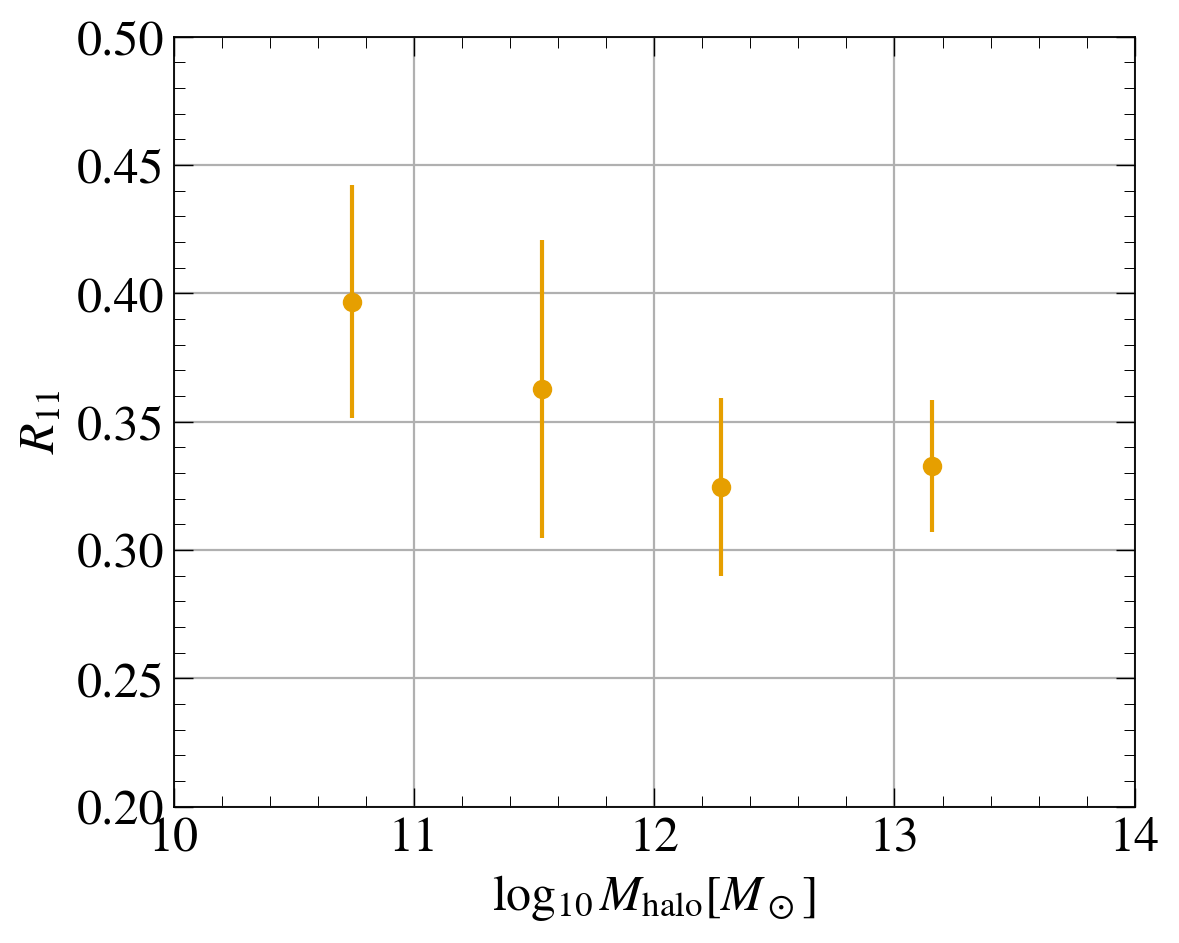

In [114]:
plt.errorbar(mean_mass,R11_mean,yerr=R11_std,fmt='o')
plt.xlim(10,14)
plt.ylim(0.2,0.5)
plt.xlabel(r"$\log_{10} M_{\rm halo} [M_\odot]$")
plt.ylabel(r"$R_{11}$")

In [8]:
nbins = 4
R11_result = []
for i in trange(nbins):
    gal_list_path = "../data/gal_list_{}.pkl".format(i)
    pdata, mdata, R11, R11sd, m, msd, c, csd = mmt.run_mdet_sims(halo_df,
        sim_func=sim_func,
        sim_kwargs={
            "noise": 420
        },
        seed=123,
        n_sims=100,
        use_p=True,
        use_m=True)
    R11_result.append((R11,R11sd))

  0%|          | 0/4 [00:00<?, ?it/s]

Using both positive and negative shear
x1 is [ 1.07751101e-01  1.87514696e+00  5.95545182e-01 -4.93466604e-01
  6.01389931e-02  3.40094817e-01  1.06509570e+00  1.18166411e-01
  5.26414698e-01  1.45756755e-01  6.24305613e-01  6.98609254e-01
 -3.02283405e-01  3.10088806e-01  4.72519948e-01  5.30155285e-02
  3.87014925e-01  5.38793581e-01  6.96344492e-01 -5.93193131e-01
  6.30502039e-01 -7.00822553e-02  2.91715921e-01  4.02513684e-01
 -4.48168163e-02  5.04165328e-01  2.25041468e-02 -8.91764880e-02
  2.14454528e-01  9.80839658e-02  5.77909570e-01  5.59066184e-01
  5.06773204e-01  1.53380180e-01  9.95039555e-01  6.23494605e-01
 -1.70850900e-01  3.59827452e-01 -6.53056111e-02  4.41354103e-01
 -1.67854688e-01  3.88567212e-01  1.03130724e+00  2.16607823e-01
 -3.83530871e-01  8.05349968e-01  7.56718469e-01  4.67278340e-01
  1.21794341e-01 -2.15433376e-01 -2.41711657e-01 -4.35896430e-01
  2.66459061e-02  3.50123467e-01  5.78417619e-01  3.60909593e-01
  4.39776437e-01 -6.29231775e-01  2.74915742e

 25%|██▌       | 1/4 [02:42<08:07, 162.42s/it]

Using both positive and negative shear
x1 is [-1.24366236e-02  8.72535148e-01  4.67300904e-01 -4.34617933e-01
  8.67355584e-02  2.31947210e-01  8.32769707e-01  3.59417559e-02
  4.18657704e-01  5.52661263e-01  7.00345777e-01 -3.20802100e-01
  1.97451973e-01  2.39081812e-01  3.27626377e-02  4.19387629e-01
  2.07591318e-01 -5.84663990e-01  5.14508242e-01 -1.68662557e-01
  1.46015036e-01  4.64063760e-01 -5.14844636e-02  3.47056116e-01
 -7.73410346e-03 -9.62275222e-02  8.35883677e-02  4.87227838e-02
 -4.62903240e-01  3.95019164e-01  4.48467571e-01 -7.65347391e-02
  5.75693676e-01  3.30147092e-01  1.93043219e-01  3.55590923e-01
 -3.98780111e-02  4.10954563e-01 -1.65665490e-01  2.97042565e-01
  7.08747774e-01  2.10424982e-01  1.03732864e-01  5.82734350e-01
  4.30754450e-01  3.09811596e-01  7.78472999e-02 -2.26016978e-01
 -2.79304321e-01 -3.48272334e-01 -2.79236741e-02  3.31011239e-01
  4.44154636e-01  3.48588113e-01 -4.83833961e-01  1.38387561e-01
  1.66226661e-01 -5.66252330e-01 -2.78680882e

 50%|█████     | 2/4 [05:26<05:27, 163.51s/it]

Using both positive and negative shear
x1 is [-6.99161516e-03  5.88565353e-01  8.16852842e-01 -1.09430136e-01
  2.41213054e-01 -8.47517200e-01 -6.93887137e-01 -1.15900862e-01
  3.95013643e-01 -1.36440439e-01  5.00248589e-01 -2.73486894e-01
  3.92680827e-01 -2.83734405e-01 -4.02334890e-01  7.25049379e-02
  7.08152588e-01 -5.73809807e-02 -7.60016081e-01  3.43682856e-01
 -1.00439154e+00 -5.35207147e-01  4.97250484e-01  3.68786636e-01
 -1.05344799e-01 -3.60398247e-01  2.28142927e-01  1.55474628e-01
  5.39974115e-01  2.38641518e-01  3.84417410e-01  6.66124403e-01
  8.69527908e-01 -4.14418054e-01  1.98419149e-01 -1.86289484e-02
  9.55180881e-01 -5.33514022e-02  2.40867647e-01 -1.82680456e-01
  1.99834595e-01  3.54831016e-01  1.43242566e-03  4.27374301e-01
  3.82060000e-01 -6.50416467e-01  4.03118786e-01 -4.23503437e-01
  3.40824681e-02  9.70345748e-01  2.13332381e-01  4.53062078e-02
 -4.41529692e-01  1.44831046e-04 -4.40079673e-01  3.82237238e-01
  5.06991350e-01  6.71434479e-02 -2.37133443e

 75%|███████▌  | 3/4 [08:08<02:42, 162.91s/it]

Using both positive and negative shear
x1 is [0.21199131 0.36855575 0.26635703 0.09813135 0.22463132 0.23978349
 0.33594243 0.18515187 0.29278314 0.31485525 0.13467712 0.26079101
 0.24607641 0.22489297 0.22235625 0.12993189 0.18348133 0.19726074
 0.28143089 0.21317044 0.19954268 0.2465512  0.21671861 0.26159807
 0.25933019 0.23608721 0.29814308 0.22267244 0.27166901 0.18475115
 0.16782343 0.26402188 0.1659504  0.30088733 0.23812369 0.15621458
 0.1526544  0.20368017 0.24963219 0.27073444 0.26540936 0.1031508
 0.24787938 0.07824086 0.15737233 0.29171869 0.25732814 0.19370688
 0.28379465 0.17403884 0.23588206 0.24302627 0.28707001 0.27550405
 0.24631572 0.23208176 0.14190376 0.25456973 0.2131649  0.24070573
 0.32583438 0.27520645 0.15277422 0.29238569 0.28413243 0.28191829
 0.29121902 0.33926015 0.28030743 0.22550368 0.16329101 0.23068382
 0.2925207  0.22431178 0.33365136 0.34050662 0.23995908 0.21453295
 0.2393581  0.23696859 0.2407583  0.24836793 0.1590844  0.25484938
 0.25305408 0.2106

100%|██████████| 4/4 [10:50<00:00, 162.60s/it]


In [ ]:
import pickle
with open('../output/R11_result.pkl', 'wb') as f:
    pickle.dump(R11_result, f)